In [ ]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/datasets.git


  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-uc1808gz
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-uc1808gz
  Resolved https://github.com/huggingface/transformers.git to commit eab6c491d439e83d5e31c660df6f7e36592eb0a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-hdcyyb73
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-hdcyyb73
  Resolved https://github.com/huggingface/peft.git to commit 8eeae0a63f28a80ef42b6bfc977c34ffc0b650ff
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metada

In [ ]:
!pip install torch tqdm


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch

In [ ]:
!pip install -U bitsandbytes


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
# 1. Load the base LLaMA model and tokenizer
model_name = "unsloth/gemma-2-9b-bnb-4bit"  # Replace with your model path
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Ensure the adapter is loaded correctly
adapter_name = "DrishtiSharma/gemma-2-9b-FMD-001"  # Replace with your adapter's name
base_model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
model = PeftModel.from_pretrained(base_model, adapter_name)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


model.safetensors:   0%|          | 0.00/6.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/216M [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset


In [ ]:
import pandas as pd

In [ ]:
import pandas as pd
splits = {'Train': 'FINNLP-train.csv', 'Dev': 'FINNLP-dev.csv'}
df_train = pd.read_csv("hf://datasets/1-800-SHARED-TASKS/COLING-2025-FINNLP-FMD/" + splits["Train"])
df_dev   = pd.read_csv("hf://datasets/1-800-SHARED-TASKS/COLING-2025-FINNLP-FMD/" + splits["Dev"])
print(len(df_train))
print(len(df_dev))

1500
453


In [ ]:
import random
label_mapping = {"True": "True", "NEI": "Neutral", "False": "False"}
df_train['label'] = df_train['label'].map(label_mapping)
df_dev['label'] = df_dev['label'].map(label_mapping)

In [ ]:
from datasets import Dataset
train_dataset    = Dataset.from_pandas(df_train)
dev_dataset      = Dataset.from_pandas(df_dev)

In [ ]:
!pip install tqdm
from tqdm.auto import tqdm


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
import pandas as pd
val_df = pd.DataFrame(dev_dataset)

In [ ]:
val_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   claim          453 non-null    object
 1   sci_digest     453 non-null    object
 2   justification  453 non-null    object
 3   issues         453 non-null    object
 4   label          453 non-null    object
 5   evidence       453 non-null    object
dtypes: object(6)
memory usage: 21.4+ KB


In [ ]:
prompt_template = """
### Instruction:
Your task is to classify the given claim accurately by assigning the most appropriate label, using the justification provided. Follow these steps to determine the most suitable label:

1. Carefully analyze both the claim and the justification provided.
2. Select the most appropriate label from the following options that best represents the claim's accuracy:
   - True: The claim is factually correct based on the information in the justification.
   - Neutral: The justification does not provide enough information to verify or deny the claim.
   - False: The claim is factually incorrect according to the justification.

After selecting the most appropriate label, provide a concise and clear explanation to justify your label choice, ensuring it aligns directly with the information presented in the justification.

### Important Notes:
- Make sure your label reflects the claim’s accuracy as determined by the justification.
- The explanation should be specific, directly addressing the reasoning behind your label choice.

### Claim:
{claim}

### Justification:
{justification}

### Response:
"""

In [ ]:
EOS_TOKEN = tokenizer.eos_token


In [ ]:
trail_df = val_df[:1]

In [ ]:
for index, row in tqdm(trail_df.iterrows(), total=trail_df.shape[0], desc="Making Predictions"):
  inputs = tokenizer([prompt_template.format(claim=row['claim'],justification=row['justification'])],return_tensors="pt").to("cuda")
  outputs = model.generate(**inputs, max_new_tokens=64, num_return_sequences=1, do_sample=False, eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,)
  decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
  response_1 = ""
  if "### Response:" in decoded_output:
    start_index = decoded_output.index("### Response:") + len("### Response:")
    end_index = decoded_output.find("###", start_index)
    if end_index != -1:
      response_1 = decoded_output[start_index:end_index].strip()
    else:
      response_1 = decoded_output[start_index:].strip()
  print(f"Response 1: {response_1}")


Making Predictions:   0%|          | 0/1 [00:00<?, ?it/s]

Response 1: The claim is False.


In [ ]:
for index, row in tqdm(val_df.iterrows(), total=val_df.shape[0], desc="Making Predictions"):
  inputs = tokenizer([prompt_template.format(claim=row['claim'],justification=row['justification'])],return_tensors="pt").to("cuda")
  outputs = model.generate(**inputs, max_new_tokens=10, num_return_sequences=1, do_sample=False, eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,)
  decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
  response_1 = ""
  if "### Response:" in decoded_output:
    start_index = decoded_output.index("### Response:") + len("### Response:")
    end_index = decoded_output.find("###", start_index)
    if end_index != -1:
      response_1 = decoded_output[start_index:end_index].strip()
    else:
      response_1 = decoded_output[start_index:].strip()
  val_df.at[index, 'pred'] = response_1

Making Predictions:   0%|          | 0/453 [00:00<?, ?it/s]

In [ ]:
val_df


,claim,sci_digest,justification,issues,label,evidence,pred
0,Did Tampered-With Conditioner Cause a Wisconsi...,['A mother and daughter sounded the alarm over...,"In late summer 2019, multiple news accounts re...",['loss'],Neutral,"On Aug. 1, the website Distractify published a...",The claim is False.
1,Was a Texting Driver Found Still Clutching a P...,"['A photograph of a car crash scene is real, b...",An alarming photograph of a car after it was i...,['share'],False,An alarming photograph of a car after it was i...,The claim is False. The justification does not...
2,"After shedding jobs for more than 10 years, ou...",[],At several points in his State of the Union Ad...,"['National', 'Economy', 'Jobs']",True,At several points in his State of the Union Ad...,The claim is True. The justification provides ...
3,State Dept. Employee Candace Claiborne Arreste...,['Department of State employee Candace Claibor...,"In mid-April 2017, multiple online sources rep...",['profit'],Neutral,"In mid-April 2017, multiple online sources rep...",False
4,"Does US Rank No. 1 in Incarceration, Gas Consu...","['""We\'re number one"" isn\'t always a point of...","In April 2021, users of the online forum Reddi...",['economy'],Neutral,"The meme was posted to the ""/facepalm"" sub-red...",The claim is true. The United States is the
...,...,...,...,...,...,...,...
448,Betty White on 'Grow Some Balls',"[""A popular joke about the wisdom of the sayin...",A popular meme circulating since 2011 via the ...,['credit'],False,But while the observation has much of the cade...,False
449,Did Donald Trump claim that the Earth is flat?,['Rumors that the President-elect believes the...,"In December 2016, rumors flew about Donald Tru...",['taxes'],False,"In December 2016, rumors flew about Donald Tru...",The claim is False. The justification provides...
450,Did Nick Saban Endorse Joe Biden?,"['As far as we can tell, the University of Ala...",An image supposedly showing a meme that was po...,['insurance'],False,This image was not shared to Biden's Facebook ...,The claim is False. The image does not show
451,Volkswagen Passat,['High mileage Volkswagen Passat automobiles c...,Claim: The U.S. government prohibits high mil...,['economy'],False,https://www.volkswagen.co.uk/#/new/passat-esta...,


In [ ]:
def standardize_truth_values(value):
    value = str(value).lower()
    if 'true' in value:
        return 'True'
    elif 'false' in value:
        return 'False'
    else:
        return 'Neutral'
val_df['pred'] = val_df['pred'].apply(standardize_truth_values)
val_df

,claim,sci_digest,justification,issues,label,evidence,pred
0,Did Tampered-With Conditioner Cause a Wisconsi...,['A mother and daughter sounded the alarm over...,"In late summer 2019, multiple news accounts re...",['loss'],Neutral,"On Aug. 1, the website Distractify published a...",False
1,Was a Texting Driver Found Still Clutching a P...,"['A photograph of a car crash scene is real, b...",An alarming photograph of a car after it was i...,['share'],False,An alarming photograph of a car after it was i...,False
2,"After shedding jobs for more than 10 years, ou...",[],At several points in his State of the Union Ad...,"['National', 'Economy', 'Jobs']",True,At several points in his State of the Union Ad...,True
3,State Dept. Employee Candace Claiborne Arreste...,['Department of State employee Candace Claibor...,"In mid-April 2017, multiple online sources rep...",['profit'],Neutral,"In mid-April 2017, multiple online sources rep...",False
4,"Does US Rank No. 1 in Incarceration, Gas Consu...","['""We\'re number one"" isn\'t always a point of...","In April 2021, users of the online forum Reddi...",['economy'],Neutral,"The meme was posted to the ""/facepalm"" sub-red...",True
...,...,...,...,...,...,...,...
448,Betty White on 'Grow Some Balls',"[""A popular joke about the wisdom of the sayin...",A popular meme circulating since 2011 via the ...,['credit'],False,But while the observation has much of the cade...,False
449,Did Donald Trump claim that the Earth is flat?,['Rumors that the President-elect believes the...,"In December 2016, rumors flew about Donald Tru...",['taxes'],False,"In December 2016, rumors flew about Donald Tru...",False
450,Did Nick Saban Endorse Joe Biden?,"['As far as we can tell, the University of Ala...",An image supposedly showing a meme that was po...,['insurance'],False,This image was not shared to Biden's Facebook ...,False
451,Volkswagen Passat,['High mileage Volkswagen Passat automobiles c...,Claim: The U.S. government prohibits high mil...,['economy'],False,https://www.volkswagen.co.uk/#/new/passat-esta...,Neutral


In [ ]:
val_df['pred'].value_counts()

pred
False      249
True       126
Neutral     78
Name: count, dtype: int64

In [ ]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!pip install scikit-learn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 42.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 48.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


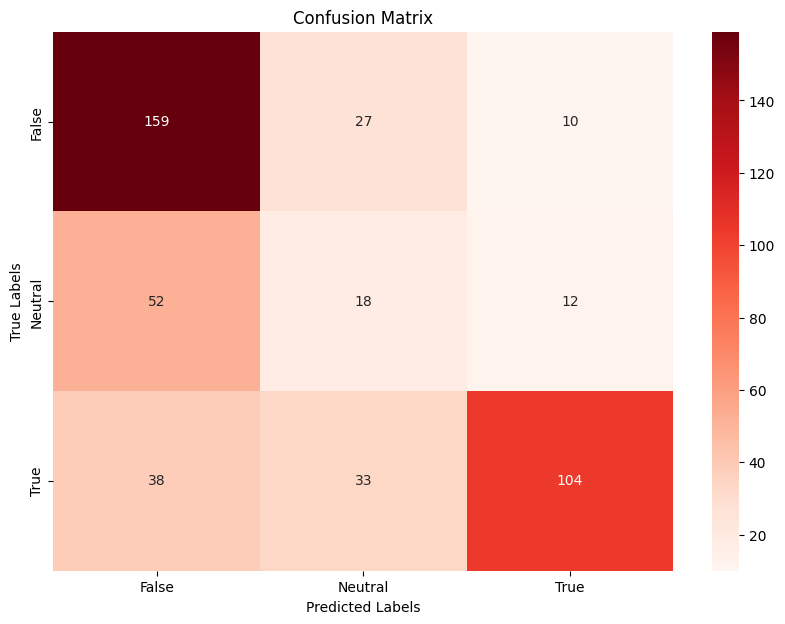

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
labels = sorted(set(val_df['label']))  # Sorts labels
cm = confusion_matrix(val_df['label'], val_df['pred'], labels=labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
micro_f1 = f1_score(val_df['label'], val_df['pred'], average='micro')
print("Micro F1 Score (Overall):", micro_f1)

Micro F1 Score (Overall): 0.6203090507726269


In [ ]:
val_df.to_csv('GEMMA2-9B-FMD-R1-001-preds.csv', index=False)